In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

import collections
import re, string
import sys
import time
import os


In [2]:
import json
import csv

def init_dataset(json) -> tuple[dict, list]:
    ds: dict = {}
    keys = json.keys()
    for k in keys:
        ds[k] = []
    return ds, keys

def read_json(file) -> pd.DataFrame:
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            json_line = json.loads(line.strip())
            if count == 0:
                dataset, keys = init_dataset(json_line)
            for k in keys:
                dataset[k].append(json_line[k])
        return pd.DataFrame(dataset)

def read_csv(file) -> pd.DataFrame:
    dataset = {}
    with open(file, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        keys = reader.fieldnames
        for k in keys:
            dataset[k] = []
        for row in reader:
            for k in keys:
                dataset[k].append(row[k])
    return pd.DataFrame(dataset)


In [3]:
#yelp_review = read_json('data/yelp_academic_dataset_review.json')
yelp_review = read_csv('data/yelp_academic_dataset_review.csv')

In [4]:
#yelp_business = read_json('data/yelp_academic_dataset_business.json')
yelp_business = read_csv('data/yelp_academic_dataset_business.csv')

In [5]:
# Sample Data: Restaurants reviewed by karen, the user with the most reviews
# Businesses that are categorized as restaurants
business_restaurant = yelp_business.loc[yelp_business['categories'].str.contains('Restaurant', na=False)]
# Reviews of Restaurant businesses
review_restaurant = yelp_review[yelp_review['business_id'].isin(business_restaurant['business_id'])]
# User with most restaurant reviews
karen = review_restaurant['user_id'].value_counts().index[0]
# Reviews Karen has made of restaurant businesses
review_restaurant_karen = review_restaurant.loc[review_restaurant['user_id'] == karen]
# Restaurant businesses that Karen has reviewed
business_restaurant_karen = business_restaurant[business_restaurant['business_id'].isin(review_restaurant_karen['business_id'])]

In [6]:
## Clean Data: remove missing rows and irrelevant columns
df = business_restaurant_karen.set_index('business_id')

# Remove columns with greater than 20% missing fields
mask = df.applymap(lambda x: x =='' or x == 'None').sum()
features = ((mask/len(df)) * 100).map(lambda x: x < 20)


# Remove non-attribute columns (except business_id)
features.loc[~features.index.str.contains('attributes.')] = False
#features.loc['business_id'] = True
dataset = df.loc[:, features]

# Remove rows with missing data
mask = dataset.applymap(lambda x: x == '' or x == 'None')
dataset = dataset.loc[~mask.any(axis=1)]

# Remove all non-boolean columns
mask = dataset.applymap(lambda x : x == 'True' or x == 'False').sum() != 0
#mask.loc['business_id'] = True
#dataset = dataset.set_index('business_id')
dataset = dataset.loc[:, mask].applymap(lambda x: x == 'True')

In [7]:
# Transform Data: add targets
df = review_restaurant_karen.set_index('business_id')
df = df.loc[df.index.intersection(dataset.index)]
df = df.astype({'stars':'float'})
dataset['target'] = df.groupby(df.index)['stars'].mean().map(lambda x: x > 3)

In [8]:
# Delineate between traning and testing set
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

### Logistic Regression Classifier using Newton's Method

In [55]:
import matplotlib.pyplot as plt

import util
from linear_model import LinearModel

lamb = lambda x: 1. if x == True else 0.
y_train = train_df['target'].map(lamb).to_numpy()
x_train = train_df.drop(['target'], axis=1).applymap(lamb).to_numpy()

y_test = test_df['target'].map(lamb).to_numpy()
x_test = test_df.drop(['target'], axis=1).applymap(lamb).to_numpy()
x_test.shape

(138, 10)

In [46]:
# hypothesis function... sigmoid function
def g(theta, x):
    return 1 / (1 + np.exp(-x @ theta))

# matrix derivative
def dJ(theta, x, y):
    m, _ = x.shape
    return 1/m* x.T @ (g(theta, x) - y)

# hessian matrix
def HJ(theta, x):
    m, _ = x.shape
    Z = sigmoid_func(theta, x)
    Z = Z*(1-Z)
    return 1/m * Z * x.T @ x

# distance between two vectors
def dist(x, y):
    return np.sum(np.abs(x-y))

In [47]:
class LogisticRegression(LinearModel):
    def fit(self, x, y):
        m, n = x.shape
        if self.theta is None:
            self.theta=np.zeros(n)
        for i in range(self.max_iter):
            theta_new = self.theta - np.linalg.inv(HJ(self.theta, x)) @ dJ(self.theta, x, y)
            if dist(theta_new, self.theta) < self.eps:
                self.theta = theta_new
                break
            else:
                self.theta = theta_new

    def predict(self, x):
        return x @ self.theta >=0

In [48]:
lg1 = LogisticRegression()
lg1.fit(x_train, y_train)

Theta:  [ 0.59714209  0.49508892 -0.042109   -0.08595731  0.51446855 -0.48017102
  0.13016552 -0.64661731 -0.19983955  0.52538337]
Training accuracy:  0.6076642335766423


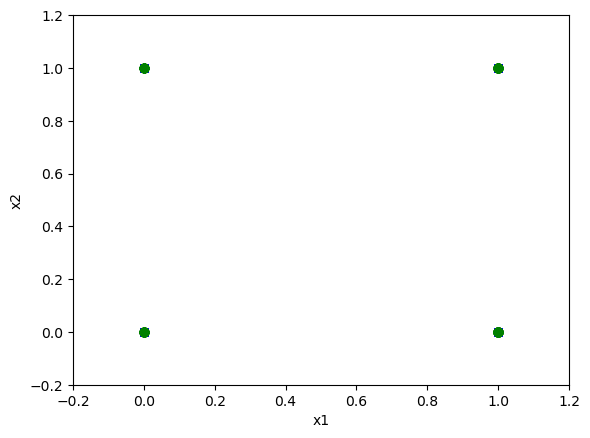

In [51]:
util.plot(x_train, y_train, theta=lg1.theta)
print("Theta: ", lg1.theta)
print("Training accuracy: ", np.mean(lg1.predict(x_train) == y_train))

Validation accuracy:  0.6014492753623188


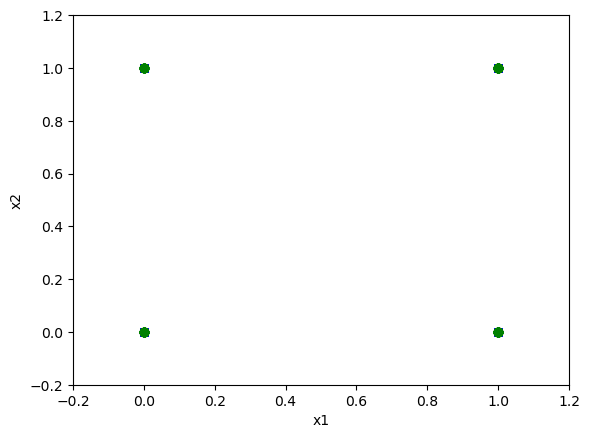

In [53]:
util.plot(x_test, y_test, theta=lg1.theta)
print("Validation accuracy: ", np.mean(lg1.predict(x_test) == y_test))

In [10]:
os.makedirs('data_host/SAMPLES', exist_ok=True)
# review_restaurant_karen.to_csv('data_host/SAMPLES/review_restaurant_karen.csv')
# business_restaurant_karen.to_csv('data_host/SAMPLES/business_restaurant_karen.csv')
dataset = dataset.applymap(lambda x: 1 if x == True else 0)
dataset.to_csv('data_host/SAMPLES/dataset.csv')